#### Code Reference: https://github.com/nfmcclure/tensorflow_cookbook/blob/master/09_Recurrent_Neural_Networks/03_Implementing_LSTM/03_implementing_lstm.py

# Importing the libraries

In [2]:
import tensorflow as tf
from tensorflow.python.framework import ops
import numpy as np
import string, re, os
import requests
import collections
import random

# Load data

In [3]:
data_dir = 'data'
data_file = 'shakespeare.txt'
if not os.path.isfile(os.path.join(data_dir, data_file)):
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    print('Data file not found, downloading the dataset')
    shakespeare_url = 'http://www.gutenberg.org/cache/epub/100/pg100.txt'
    response = requests.get(shakespeare_url)
    shakespeare_file = response.content
    # Decode binary into string
    s_text = shakespeare_file.decode('utf-8')
    # Drop first few descriptive paragraphs.
    s_text = s_text[7675:]
    # Remove newlines
    s_text = s_text.replace('\r\n', '')
    s_text = s_text.replace('\n', '')
    # Write to file
    with open(os.path.join(data_dir, data_file), 'w') as out_conn:
        out_conn.write(s_text)
else:
    with open(os.path.join(data_dir, data_file), 'r') as file_conn:
        s_text = file_conn.read().replace('\n', '')
print('Sample data:\n'+ s_text[:200])

Sample data:
From fairest creatures we desire increase,  That thereby beauty's rose might never die,  But as the riper should by time decease,  His tender heir might bear his memory:  But thou contracted to thine 


# Clean data

### Declare punctuation to remove, everything except hyphens and apostrophes

In [4]:
punctuation = string.punctuation
punctuation = ''.join([x for x in punctuation if x not in ['-', "'"]])
s_text = re.sub(r'[{}]'.format(punctuation), ' ', s_text)
s_text = re.sub('\s+', ' ', s_text).strip().lower()

# Build Vocabulary

In [5]:
def build_vocab(text, min_word_freq):
    word_counts = collections.Counter(text.split(' '))
    print ('word counts: ', len(word_counts), 'text len: ', len(text.split(' ')))
    # limit word counts to those more frequent than cutoff
    word_counts = {key: val for key, val in word_counts.items() if val > min_word_freq}
    # Create vocab --> index mapping
    words = word_counts.keys()
    vocab_to_ix_dict = {key: (ix + 1) for ix, key in enumerate(words)}
    # Add unknown key --> 0 index
    vocab_to_ix_dict['unknown'] = 0
    # Create index --> vocab mapping
    ix_to_vocab_dict = {val: key for key, val in vocab_to_ix_dict.items()}
    return (ix_to_vocab_dict, vocab_to_ix_dict)

# Build Shakespeare vocabulary
min_word_freq = 5  # Trim the less frequent words off
ix2vocab, vocab2ix = build_vocab(s_text, min_word_freq)
vocab_size = len(ix2vocab) + 1
print('Vocabulary Length = {}'.format(vocab_size))
# Sanity Check
assert (len(ix2vocab) == len(vocab2ix))

('word counts: ', 31953, 'text len: ', 901088)
Vocabulary Length = 8009


# Convert text to word Vectors

In [6]:
s_text_words = s_text.split(' ')
s_text_ix = []
for ix, x in enumerate(s_text_words):
    try:
        s_text_ix.append(vocab2ix[x])
    except:
        s_text_ix.append(0)
s_text_ix = np.array(s_text_ix)

# LSTM RNN Model

In [7]:
class LSTM_Model():
    def __init__(self, rnn_size, batch_size, learning_rate,
                 training_seq_len, vocab_size, infer_sample=False):
        self.rnn_size = rnn_size
        self.vocab_size = vocab_size
        self.infer_sample = infer_sample
        self.learning_rate = learning_rate

        if infer_sample:
            self.batch_size = 1
            self.training_seq_len = 1
        else:
            self.batch_size = batch_size
            self.training_seq_len = training_seq_len

        self.lstm_cell = tf.contrib.rnn.core_rnn_cell.BasicLSTMCell(rnn_size)
        self.initial_state = self.lstm_cell.zero_state(self.batch_size, tf.float32)

        self.x_data = tf.placeholder(tf.int32, [self.batch_size, self.training_seq_len])
        self.y_output = tf.placeholder(tf.int32, [self.batch_size, self.training_seq_len])

        with tf.variable_scope('lstm_vars'):
            # Softmax Output Weights
            W = tf.get_variable('W', [self.rnn_size, self.vocab_size], tf.float32, tf.random_normal_initializer())
            b = tf.get_variable('b', [self.vocab_size], tf.float32, tf.constant_initializer(0.0))

            # Define Embedding
            embedding_mat = tf.get_variable('embedding_mat', [self.vocab_size, self.rnn_size],
                                            tf.float32, tf.random_normal_initializer())
            print('xdata:', self.x_data.get_shape())
            print('emb_mat: ', embedding_mat.get_shape())
            embedding_output = tf.nn.embedding_lookup(embedding_mat, self.x_data)
            print('emb_output: ', embedding_output.get_shape())
            rnn_inputs = tf.split(axis=1, num_or_size_splits=self.training_seq_len, value=embedding_output)
            print('rnninputs: ', len(rnn_inputs), rnn_inputs[0].get_shape())
            rnn_inputs_trimmed = [tf.squeeze(x, [1]) for x in rnn_inputs]
            print('rnninput trimmed:', len(rnn_inputs_trimmed), rnn_inputs_trimmed[0].get_shape())

            # If we are inferring (generating text), we add a 'loop' function
            # Define how to get the i+1 th input from the i th output
            def inferred_loop(prev, count):
                # Apply hidden layer
                prev_transformed = tf.matmul(prev, W) + b
                # Get the index of the output (also don't run the gradient)
                prev_symbol = tf.stop_gradient(tf.argmax(prev_transformed, 1))
                # Get embedded vector
                output = tf.nn.embedding_lookup(embedding_mat, prev_symbol)
                return (output)

            decoder = tf.contrib.legacy_seq2seq.rnn_decoder
            outputs, last_state = decoder(rnn_inputs_trimmed,
                                          self.initial_state,
                                          self.lstm_cell,
                                          loop_function=inferred_loop if infer_sample else None)
            # Non inferred outputs
            output = tf.reshape(tf.concat(axis=1, values=outputs), [-1, self.rnn_size])
            # Logits and output
            self.logit_output = tf.matmul(output, W) + b
            self.model_output = tf.nn.softmax(self.logit_output)

            loss_fun = tf.contrib.legacy_seq2seq.sequence_loss_by_example
            loss = loss_fun([self.logit_output], [tf.reshape(self.y_output, [-1])],
                            [tf.ones([self.batch_size * self.training_seq_len])],
                            self.vocab_size)
            self.cost = tf.reduce_sum(loss) / (self.batch_size * self.training_seq_len)
            self.final_state = last_state
            gradients, _ = tf.clip_by_global_norm(tf.gradients(self.cost, tf.trainable_variables()), 4.5)
            optimizer = tf.train.AdamOptimizer(self.learning_rate)
            self.train_op = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

    def sample(self, sess, words=ix2vocab, vocab=vocab2ix, num=10, prime_text='thou art'):
        state = sess.run(self.lstm_cell.zero_state(1, tf.float32))
        word_list = prime_text.split()
        for word in word_list[:-1]:
            x = np.zeros((1, 1))
            x[0, 0] = vocab[word]
            feed_dict = {self.x_data: x, self.initial_state: state}
            [state] = sess.run([self.final_state], feed_dict=feed_dict)

        out_sentence = prime_text
        word = word_list[-1]
        for n in range(num):
            x = np.zeros((1, 1))
            x[0, 0] = vocab[word]
            feed_dict = {self.x_data: x, self.initial_state: state}
            [model_output, state] = sess.run([self.model_output, self.final_state], feed_dict=feed_dict)
            sample = np.argmax(model_output[0])
            if sample == 0:
                break
            word = words[sample]
            out_sentence = out_sentence + ' ' + word
        return (out_sentence)

In [8]:
rnn_size = 1024  # RNN Model size, has to equal embedding size
epochs = 10  # Number of epochs to cycle through data
batch_size = 32  # Train on this many examples at once
learning_rate = 0.001  # Learning rate
training_seq_len = 11  # how long of a word group to consider
embedding_size = rnn_size
eval_every = 50  # How often to evaluate the test sentences
prime_texts = ['thou art more', 'to be or not to', 'wherefore art thou']

sess = tf.Session()

# Define LSTM RNN Model
with tf.variable_scope('lstm_model') as scope:
    # Define LSTM Model
    lstm_model = LSTM_Model(rnn_size, batch_size, learning_rate,
                            training_seq_len, vocab_size)
    scope.reuse_variables()
    test_lstm_model = LSTM_Model(rnn_size, batch_size, learning_rate,
                                 training_seq_len, vocab_size, infer_sample=True)

('xdata:', TensorShape([Dimension(32), Dimension(11)]))
('emb_mat: ', TensorShape([Dimension(8009), Dimension(1024)]))
('emb_output: ', TensorShape([Dimension(32), Dimension(11), Dimension(1024)]))
('rnninputs: ', 11, TensorShape([Dimension(32), Dimension(1), Dimension(1024)]))
('rnninput trimmed:', 11, TensorShape([Dimension(32), Dimension(1024)]))
('xdata:', TensorShape([Dimension(1), Dimension(1)]))
('emb_mat: ', TensorShape([Dimension(8009), Dimension(1024)]))
('emb_output: ', TensorShape([Dimension(1), Dimension(1), Dimension(1024)]))
('rnninputs: ', 1, TensorShape([Dimension(1), Dimension(1), Dimension(1024)]))
('rnninput trimmed:', 1, TensorShape([Dimension(1), Dimension(1024)]))


# Train Model

## Create batches

In [9]:
num_batches = int(len(s_text_ix) / (batch_size * training_seq_len)) + 1
# Split up text indices into subarrays, of equal size
batches = np.array_split(s_text_ix, num_batches)
# Reshape each split into [batch_size, training_seq_len]
batches = [np.resize(x, [batch_size, training_seq_len]) for x in batches]

## Initialize variables

In [10]:
init = tf.global_variables_initializer()
sess.run(init)

## Start Training

In [11]:
train_loss = []
iteration_count = 1
for epoch in range(epochs):
    # Shuffle word indices
    random.shuffle(batches)
    # Create targets from shuffled batches
    targets = [np.roll(x, -1, axis=1) for x in batches]
    # Run a through one epoch
    print('Starting Epoch #{} of {}.'.format(epoch + 1, epochs))
    # Reset initial LSTM state every epoch
    state = sess.run(lstm_model.initial_state)
    for ix, batch in enumerate(batches):
        training_dict = {lstm_model.x_data: batch, lstm_model.y_output: targets[ix]}
        c, h = lstm_model.initial_state
        training_dict[c] = state.c
        training_dict[h] = state.h

        temp_loss, state, _ = sess.run([lstm_model.cost, lstm_model.final_state, lstm_model.train_op],
                                       feed_dict=training_dict)
        train_loss.append(temp_loss)

        # Print status every 10 gens
        if iteration_count % 10 == 0:
            summary_nums = (iteration_count, epoch + 1, ix + 1, num_batches + 1, temp_loss)
            print('Iteration: {}, Epoch: {}, Batch: {} out of {}, Loss: {:.2f}'.format(*summary_nums))

        if iteration_count % eval_every == 0:
            for sample in prime_texts:
                print(test_lstm_model.sample(sess, ix2vocab, vocab2ix, num=10, prime_text=sample))

        iteration_count += 1

Starting Epoch #1 of 10.
Iteration: 10, Epoch: 1, Batch: 10 out of 2561, Loss: 18.15
Iteration: 20, Epoch: 1, Batch: 20 out of 2561, Loss: 14.81
Iteration: 30, Epoch: 1, Batch: 30 out of 2561, Loss: 10.78
Iteration: 40, Epoch: 1, Batch: 40 out of 2561, Loss: 9.44
Iteration: 50, Epoch: 1, Batch: 50 out of 2561, Loss: 9.27
thou art more than than thy sword for
to be or not to the
wherefore art thou art thy phrase is worth a man in i have
Iteration: 60, Epoch: 1, Batch: 60 out of 2561, Loss: 8.85
Iteration: 70, Epoch: 1, Batch: 70 out of 2561, Loss: 8.44
Iteration: 80, Epoch: 1, Batch: 80 out of 2561, Loss: 8.00
Iteration: 90, Epoch: 1, Batch: 90 out of 2561, Loss: 8.28
Iteration: 100, Epoch: 1, Batch: 100 out of 2561, Loss: 7.85
thou art more thy hand prince john we we will be
to be or not to my
wherefore art thou art thou art thou art thou art thou art thou
Iteration: 110, Epoch: 1, Batch: 110 out of 2561, Loss: 7.69
Iteration: 120, Epoch: 1, Batch: 120 out of 2561, Loss: 7.22
Iteration

KeyboardInterrupt: 

## Plotting the training error

/Library/Python/2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


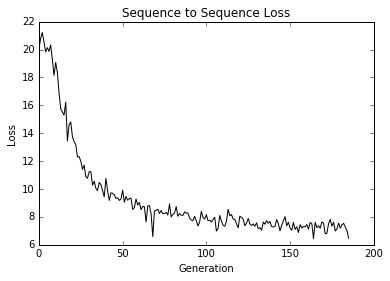

In [12]:
import matplotlib.pyplot as plt
plt.plot(train_loss, 'k-')
plt.title('Sequence to Sequence Loss')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()